# Title: Enhancing Logistic Regression Model for Telco Customer Churn Prediction || Assignment 3 
author: @nahariap@bu.edu | Prateek Naharia


**Objective:**
In this assignment, you will revisit the steps from the notebook 11-Classification-Regression/02-Logistic-Regression-Example.ipynb, applying them to the Telco-Customer-Churn dataset. Your goal is to enhance the logistic regression model using knowledge and examples from the previous three lectures. The data is located in data/Telco-Customer-Churn.csv.

## Customer Churn

Also known as customer attrition, or customer turnover is the loss of clients or customers. Customer churn is a critical metric because it is much less expensive to retain existing customers than it is to acquire new ones. 

Companies usually make a distinction between voluntary churn and involuntary churn. In most analyses involuntary churn is excluded. 

Predictive analytics uses machine learning to predict the likelihood of a customer churning. These models will identify a small subgroup of potential customers that are at a higher risk of abandoning the company. This empowers the company to focus on the subset of the customers who are most likely to churn and through customer retention marketing programs stop some of that to happen.


## Data

**Telco Customer Churn**

The data was downloaded from IBM Sample Data Sets: https://www.ibm.com/communities/analytics/watson-analytics-blog/guide-to-sample-datasets/

Each row represents a customer, each column contains customer's attributes described as below:

* **customerID**: Customer ID
* **gender**: Customer gender (female, male)
* **SeniorCitizen**: Whether the customer is a senior citizen or not (1, 0)
* **Partner**: Whether the customer has a partner or not (Yes, No)
* **Dependents**: Whether the customer has dependents or not (Yes, No)
* **tenure**: Number of months the customer has stayed with the company
* **PhoneService**: Whether the customer has a phone service or not (Yes, No)
* **MultipleLines**: Whether the customer has multiple lines or not (Yes, No, No phone service)
* **InternetService**: Customer's internet service provider (DSL, Fiber optic, No)
* **OnlineSecurity**: Whether the customer has online security or not (Yes, No, No internet service)
* **OnlineBackup**: Whether the customer has online backup or not (Yes, No, No internet service)
* **DeviceProtection**: Whether the customer has device protection or not (Yes, No, No internet service)
* **TechSupport**: Whether the customer has tech support or not (Yes, No, No internet service)
* **StreamingTV**: Whether the customer has streaming TV or not (Yes, No, No internet service)
* **StreamingMovies**: Whether the customer has streaming movies or not (Yes, No, No internet service)
* **Contract**: The contract term of the customer (Month-to-month, One year, Two year)
* **PaperlessBilling**: Whether the customer has paperless billing or not (Yes, No)
* **PaymentMethod**: The customer's payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
* **MonthlyCharges**: The amount charged to the customer monthly
* **TotalCharges**: The total amount charged to the customer
* **Churn**: Whether the customer churned or not (Yes or No)

The data set includes information about:

* Customers who left - the column is called `Churn`
* Services that each customer has signed up for - phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
* Customer account information - how long they've been a customer, contract, payment method, paperless billing, monthly charges, and total charges
* Demographic info about customers - gender, age range, and if they have partners and dependents

## 1. Data Preparation and Logistic Regression Model

Importing Libraries

In [150]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [151]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("YourAppName") \
    .config("spark.jars.packages", "com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.21.1") \
    .getOrCreate()


In [152]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.sql.functions import *
from pyspark.sql import SparkSession

# the following line gets the bucket name attached to our cluster
bucket = spark._jsc.hadoopConfiguration().get("fs.gs.system.bucket")

# specifying the path to our bucket where the data is located (no need to edit this path anymore)
data = "gs://" + bucket + "/data/"
print(data)


gs://pnqst843/data/


Importing data:

In [153]:
df = spark.read.format("csv")\
  .option("header", "true")\
  .option("inferschema", True)\
  .load(data + "Telco-Customer-Churn.csv")\
  .coalesce(5)

df = df.drop('customerID')  # Dropping customerID
df.cache()
df.show(5)
df.printSchema()
print("This datasets consists of {} rows.".format(df.count()))

+------+-------------+-------+----------+------+------------+--------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService| MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+------+-------------+-------+----------+------+------------+--------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|Female|            0|    Yes|        No|     1|          No|NoPhoneService|            DSL|            No|         Yes|              No|         No|         No|             No|Month_to_month|             

23/04/26 15:57:15 WARN CacheManager: Asked to cache already cached data.


Checking for missing values:

In [154]:
[(c, df.where(col(c).isNull()).count()) for c in df.columns]

[('gender', 0),
 ('SeniorCitizen', 0),
 ('Partner', 0),
 ('Dependents', 0),
 ('tenure', 0),
 ('PhoneService', 0),
 ('MultipleLines', 0),
 ('InternetService', 0),
 ('OnlineSecurity', 0),
 ('OnlineBackup', 0),
 ('DeviceProtection', 0),
 ('TechSupport', 0),
 ('StreamingTV', 0),
 ('StreamingMovies', 0),
 ('Contract', 0),
 ('PaperlessBilling', 0),
 ('PaymentMethod', 0),
 ('MonthlyCharges', 0),
 ('TotalCharges', 11),
 ('Churn', 0)]

From the above output, there are 11 null values in total charges

In [155]:
pd.options.display.max_columns = None  # do not truncate the middle columns
df.limit(5).toPandas()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,NoPhoneService,DSL,No,Yes,No,No,No,No,Month_to_month,Yes,ElectronicCheck,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,OneYear,No,MailedCheck,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month_to_month,Yes,MailedCheck,53.85,108.15,Yes
3,Male,0,No,No,45,No,NoPhoneService,DSL,Yes,No,Yes,Yes,No,No,OneYear,No,BankTransferAutomatic,42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,FiberOptic,No,No,No,No,No,No,Month_to_month,Yes,ElectronicCheck,70.70,151.65,Yes


In [156]:
null_totalcharges = df.filter(df['TotalCharges'].isNull())
null_totalcharges.toPandas()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,Yes,0,No,NoPhoneService,DSL,Yes,No,Yes,Yes,Yes,No,TwoYear,Yes,BankTransferAutomatic,52.55,NaN,No
1,Male,0,No,Yes,0,Yes,No,No,NoInternetService,NoInternetService,NoInternetService,NoInternetService,NoInternetService,NoInternetService,TwoYear,No,MailedCheck,20.25,NaN,No
2,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,TwoYear,No,MailedCheck,80.85,NaN,No
3,Male,0,Yes,Yes,0,Yes,Yes,No,NoInternetService,NoInternetService,NoInternetService,NoInternetService,NoInternetService,NoInternetService,TwoYear,No,MailedCheck,25.75,NaN,No
4,Female,0,Yes,Yes,0,No,NoPhoneService,DSL,Yes,Yes,Yes,Yes,Yes,No,TwoYear,No,CreditCardAutomatic,56.05,NaN,No
5,Male,0,Yes,Yes,0,Yes,No,No,NoInternetService,NoInternetService,NoInternetService,NoInternetService,NoInternetService,NoInternetService,TwoYear,No,MailedCheck,19.85,NaN,No
6,Male,0,Yes,Yes,0,Yes,Yes,No,NoInternetService,NoInternetService,NoInternetService,NoInternetService,NoInternetService,NoInternetService,TwoYear,No,MailedCheck,25.35,NaN,No
7,Female,0,Yes,Yes,0,Yes,No,No,NoInternetService,NoInternetService,NoInternetService,NoInternetService,NoInternetService,NoInternetService,TwoYear,No,MailedCheck,20.00,NaN,No
8,Male,0,Yes,Yes,0,Yes,No,No,NoInternetService,NoInternetService,NoInternetService,NoInternetService,NoInternetService,NoInternetService,OneYear,Yes,MailedCheck,19.70,NaN,No
9,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,TwoYear,No,MailedCheck,73.35,NaN,No


In [157]:
df = df.fillna(0)

### RFormula

Define an RFormula that uses all of the columns as features and call it `supervised`:

In [158]:
from pyspark.ml.feature import RFormula

supervised = RFormula(formula="Churn ~ .")
#supervised.fit(df).transform(df).show(2, False)

Fit the RFormula transformer and call it `fittedRF`:

In [159]:
fittedRF = supervised.fit(df)

Using `fittedRF` transform our `df` DataFrame. Call this `preparedDF`:

In [160]:
preparedDF = fittedRF.transform(df)

Print the first couple of rows of `preparedDF`, with the truncate option off:

In [161]:
preparedDF.show(2, truncate=False)

+------+-------------+-------+----------+------+------------+--------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+---------------+--------------+------------+-----+-----------------------------------------------------------------------------------------------------------------------+-----+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines |InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract      |PaperlessBilling|PaymentMethod  |MonthlyCharges|TotalCharges|Churn|features                                                                                                               |label|
+------+-------------+-------+----------+------+------------+--------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+---------------+---

Below we will retrieve the name of the columns used to make our feature vector and store them in a pandas DataFrame:

In [162]:
featureCols = pd.DataFrame(preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
  preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

featureCols = featureCols.set_index('idx')
featureCols.head()

# binary_features = preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["binary"]
# numeric_features = preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]
# all_features = binary_features + numeric_features
# sorted_features = sorted(all_features, key=lambda x: x['idx'])
# featureCols = pd.DataFrame(sorted_features).set_index('idx')
# featureCols.head()

,name
idx,
0,gender_Male
1,SeniorCitizen
2,Partner_No
3,Dependents_No
4,tenure


Split the transformed data into `train` and `test`. Use a 30% split and a `seed`.

In [163]:
train, test = preparedDF.randomSplit([0.7, 0.3], seed=42)


### LogisticRegression 

Instantiate an instance of `LogisticRegression`. Call it `lr`:

In [164]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression()

Print the parameters of `lr` to check the default values used. You can always come back to the cell above and change the default values:

In [165]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The bounds vector size must beequal wi

Fit the model on `train` and call it `lrModel`:

In [166]:
lrModel = lr.fit(train)

Below we plot the coefficients of our model in a sorted fashion:

Text(0, 0.5, 'Beta Coefficients')

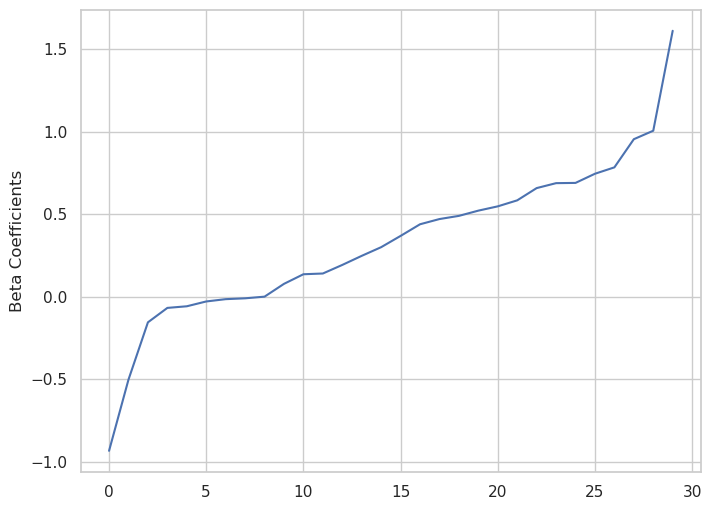

In [167]:
plt.rcParams["figure.figsize"] = (8,6)
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')

### Feature importance

We already retrieved the name of the features. Let's join it with the coefficients to identify the ones with bigger absolute value:

In [168]:
coefsArray = np.array(lrModel.coefficients)  # convert to np.array
coefsDF = pd.DataFrame(coefsArray, columns=['coefs'])  # to pandas

coefsDF = coefsDF.merge(featureCols, left_index=True, right_index=True)  # join it with featureCols we created above
coefsDF.sort_values('coefs', inplace=True)  # Sort them
coefsDF.head(10)

,coefs,name
23,-0.933980,Contract_TwoYear
9,-0.502347,InternetService_DSL
6,-0.155183,MultipleLines_No
4,-0.067761,tenure
28,-0.057943,MonthlyCharges
0,-0.028732,gender_Male
26,-0.014802,PaymentMethod_MailedCheck
2,-0.009636,Partner_No
29,0.000387,TotalCharges
27,0.077996,PaymentMethod_BankTransferAutomatic


Plot a Bar Chart

In [169]:
import seaborn as sns

# plt.rcParams["figure.figsize"] = (20,3)
# plt.xticks(rotation=90)
# plt.bar(coefsDF.name, coefsDF.coefs)
# plt.title('Ranked coefficients from the logistic regression model')
# plt.show()

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (15, 6)
plt.rcParams["font.size"] = 12

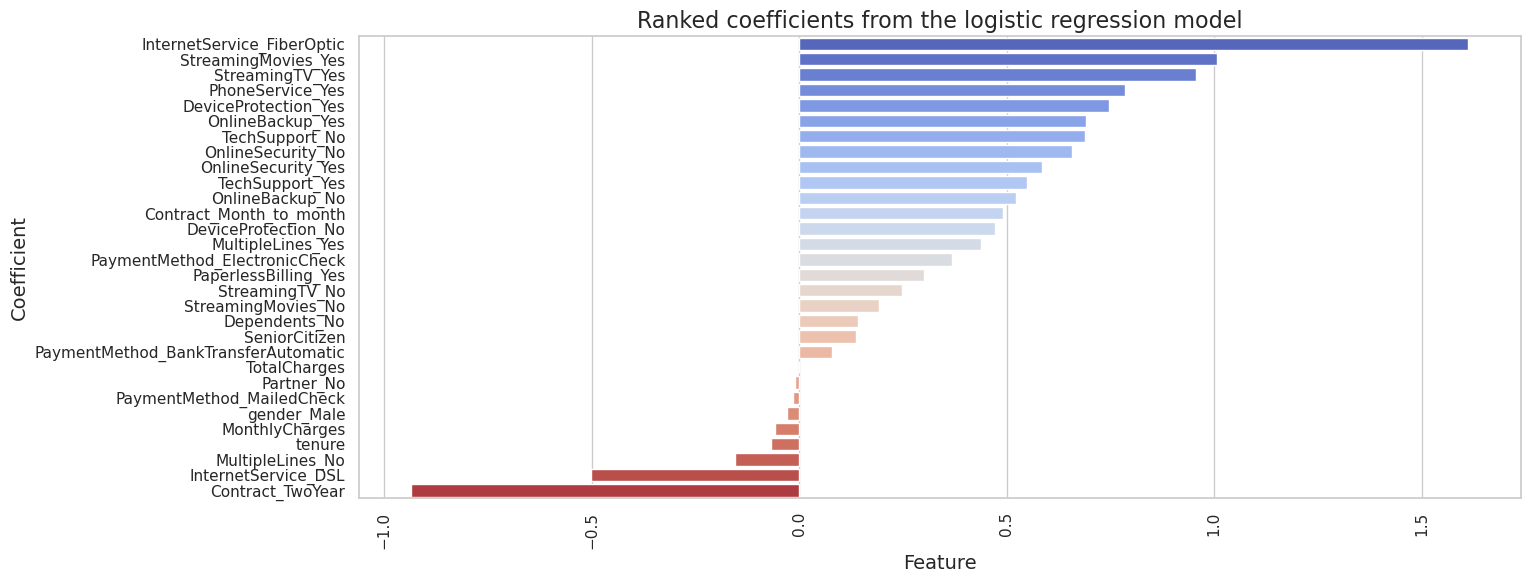

In [170]:
sorted_coefs = coefsDF.sort_values("coefs", ascending=False)
ax = sns.barplot(x="coefs", y="name", data=sorted_coefs, palette="coolwarm")
ax.set_title('Ranked coefficients from the logistic regression model', fontsize=16)
ax.set_xlabel("Feature", fontsize=14)
ax.set_ylabel("Coefficient", fontsize=14)
plt.xticks(rotation=90)
plt.show()


From our fitted model, `lrModel`, extract the summary and call it `summary`:

In [171]:
summary = lrModel.summary

From `summary` extract `areaUnderROC`. Note that this AUC is from the `train` dataset and we should pay more attention to the AUC coming from the `test` set:

In [172]:
print("AUC:", summary.areaUnderROC)

AUC: 0.8474526767588296


From `summary` extract `roc` and convert it to a pandas DataFrame. Call it `roc`:

In [173]:
roc = summary.roc.toPandas()
roc

,FPR,TPR
0,0.00000,0.000000
1,0.00000,0.003754
2,0.00027,0.006757
3,0.00027,0.010511
4,0.00054,0.013514
...,...,...
1000,0.99622,1.000000
1001,0.99757,1.000000
1002,0.99892,1.000000
1003,1.00000,1.000000


Visualize the `roc` DataFrame:


Train AUC: 0.8474526767588296


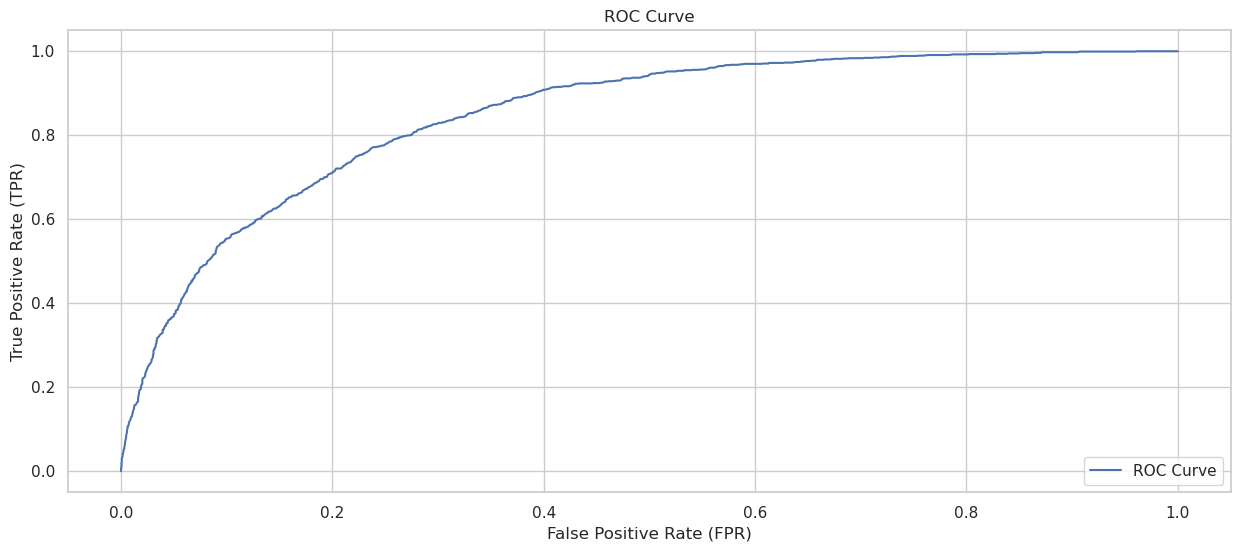

In [174]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(roc['FPR'], roc['TPR'], label='ROC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
print('Train AUC:', summary.areaUnderROC)
#plt.plot([0, 1], [0, 1], linestyle='--', color='gray') #randomclassifier diagonal line

Do the same with `pr` from `summary`:

In [175]:
pr = summary.pr.toPandas()
pr

,recall,precision
0,0.000000,1.000000
1,0.003754,1.000000
2,0.006757,0.900000
3,0.010511,0.933333
4,0.013514,0.900000
...,...,...
999,1.000000,0.265497
1000,1.000000,0.265233
1001,1.000000,0.264969
1002,1.000000,0.264706


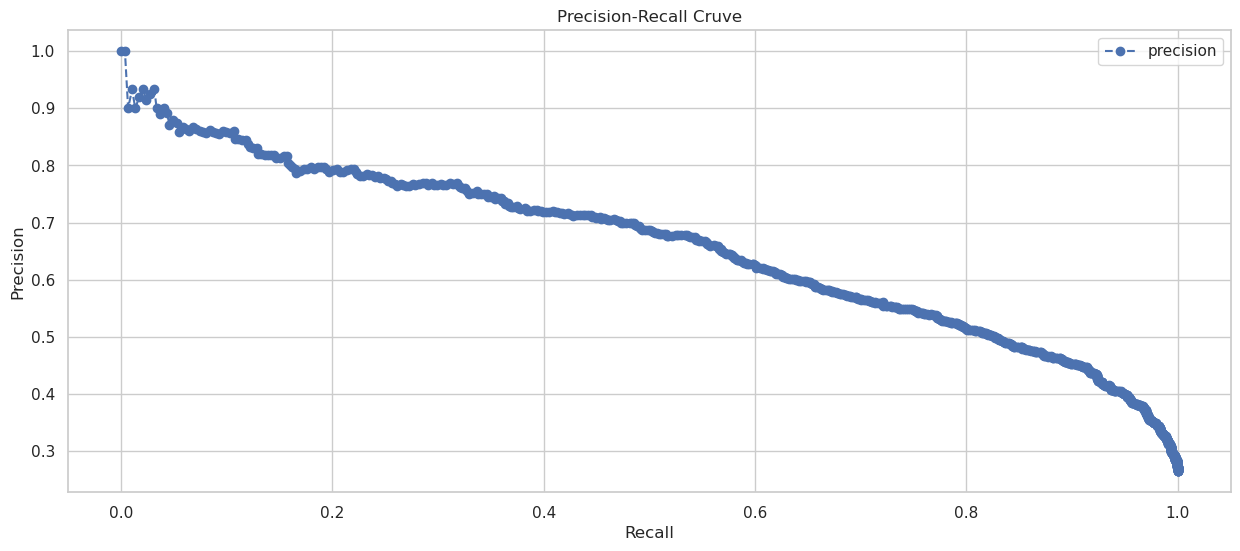

In [176]:
pr.plot(x='recall', y='precision', style='--o', legend=False)
plt.xlabel('Recall')
plt.title('Precision-Recall Cruve')
plt.ylabel('Precision')
plt.legend(loc='upper right')

Our baseline model looks promising. Let's do some predictions on the `test` set.

Pass the `test` set through our trained model. Called the resulting DataFrame `fittedTest`:

In [177]:
fittedTest = lrModel.transform(test)

Print the first few rows of this DataFrame. Only show the following columns: "label", "prediction", "rawPrediction"

In [178]:
fittedTest.select('label','prediction','rawPrediction').show(6)

+-----+----------+--------------------+
|label|prediction|       rawPrediction|
+-----+----------+--------------------+
|  0.0|       1.0|[-0.3511581527595...|
|  1.0|       1.0|[-0.2767090139105...|
|  0.0|       0.0|[0.55682764262286...|
|  1.0|       1.0|[-0.2172075913226...|
|  0.0|       0.0|[0.51122949635904...|
|  1.0|       0.0|[0.04185624638468...|
+-----+----------+--------------------+
only showing top 6 rows



Make an evaluator from `BinaryClassificationEvaluator` function that calculates AUC. We will use this function to measure our model's performance on the `test` set. Call this evaluator `aucEvaluator`. 

Note that this function can be found under the `pyspark.ml.evaluation` module.

In [179]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
aucEvaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
#fittedTest

Using our `aucEvaluator` find out the AUC on the `test` set:

In [180]:
auc_test = aucEvaluator.evaluate(fittedTest)
print(f"AUC on test set: {auc_test:.4f}")

AUC on test set: 0.8500


In [181]:
# fittedTestRDD = fittedTest.select("label", "prediction").rdd
# predictionAndLabels = fittedTestRDD.map(lambda row: (float(row.prediction), row.label))
# metrics = BinaryClassificationMetrics(predictionAndLabels)
# auc = metrics.areaUnderROC
# print("Area under ROC = %s" % auc)


In [182]:
print('AUC on Train:', summary.areaUnderROC)
print(f"AUC on test set: {auc_test:.11f}")

AUC on Train: 0.8474526767588296
AUC on test set: 0.84998036459


Q. Are your test and train AUC's within the same range?

Ans. Yes both the AUC - Test & Train are within the same range.
Overall, the results suggest that the logistic regression model is a decent classifier for this problem. However, there may still be room for improvement by experimenting with different models, feature engineering, or hyperparameter tuning.

## 2. Model Enhancement
a. Explore different options to improve the logistic regression model using knowledge and examples from the previous three lectures.

 b. Implement at least two improvements to the model (e.g., feature selection, hyperparameter tuning, or additional feature engineering).

### Feature Engineering 
Creating number of opted services & MonthlyCharges/TotalCharges giving us the rate

In [183]:
services = ['PhoneService','MultipleLines','InternetService',
            'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
            'StreamingTV','StreamingMovies']

In [184]:
from pyspark.sql.functions import col, expr
num_of_services_expr = " + ".join([f"CAST(({c} = 'Yes') as INT)" for c in services])

In [185]:
df = df.withColumn('numofservices', expr(num_of_services_expr))

In [186]:
#data = df.cache()
df = df.withColumn('charge_ratio', round(col('MonthlyCharges') / col('TotalCharges'),2))
df.limit(2).toPandas()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,numofservices,charge_ratio
0,Female,0,Yes,No,1,No,NoPhoneService,DSL,No,Yes,No,No,No,No,Month_to_month,Yes,ElectronicCheck,29.85,29.85,No,1,1.00
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,OneYear,No,MailedCheck,56.95,1889.50,No,3,0.03


In [187]:
[(c, df.where(col(c).isNull()).count()) for c in df.columns]

[('gender', 0),
 ('SeniorCitizen', 0),
 ('Partner', 0),
 ('Dependents', 0),
 ('tenure', 0),
 ('PhoneService', 0),
 ('MultipleLines', 0),
 ('InternetService', 0),
 ('OnlineSecurity', 0),
 ('OnlineBackup', 0),
 ('DeviceProtection', 0),
 ('TechSupport', 0),
 ('StreamingTV', 0),
 ('StreamingMovies', 0),
 ('Contract', 0),
 ('PaperlessBilling', 0),
 ('PaymentMethod', 0),
 ('MonthlyCharges', 0),
 ('TotalCharges', 0),
 ('Churn', 0),
 ('numofservices', 0),
 ('charge_ratio', 11)]

In [188]:
df = df.fillna(0)

In [189]:
rformula = RFormula(formula="Churn ~ . + numofservices + charge_ratio", featuresCol="features", labelCol="label")

fittedRF = rformula.fit(df)
preparedDF = fittedRF.transform(df)
train, test = preparedDF.randomSplit([0.7, 0.3], seed=42)
lrModel = lr.fit(train)

fittedTest = lrModel.transform(test)
testAUC = aucEvaluator.evaluate(fittedTest)

print(f"AUC on test set with new features: {testAUC:.4f}")

AUC on test set with new features: 0.8579


In [190]:
df.limit(10).toPandas()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,numofservices,charge_ratio
0,Female,0,Yes,No,1,No,NoPhoneService,DSL,No,Yes,No,No,No,No,Month_to_month,Yes,ElectronicCheck,29.85,29.85,No,1,1.00
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,OneYear,No,MailedCheck,56.95,1889.50,No,3,0.03
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month_to_month,Yes,MailedCheck,53.85,108.15,Yes,3,0.50
3,Male,0,No,No,45,No,NoPhoneService,DSL,Yes,No,Yes,Yes,No,No,OneYear,No,BankTransferAutomatic,42.30,1840.75,No,3,0.02
4,Female,0,No,No,2,Yes,No,FiberOptic,No,No,No,No,No,No,Month_to_month,Yes,ElectronicCheck,70.70,151.65,Yes,1,0.47
5,Female,0,No,No,8,Yes,Yes,FiberOptic,No,No,Yes,No,Yes,Yes,Month_to_month,Yes,ElectronicCheck,99.65,820.50,Yes,5,0.12
6,Male,0,No,Yes,22,Yes,Yes,FiberOptic,No,Yes,No,No,Yes,No,Month_to_month,Yes,CreditCardAutomatic,89.10,1949.40,No,4,0.05
7,Female,0,No,No,10,No,NoPhoneService,DSL,Yes,No,No,No,No,No,Month_to_month,No,MailedCheck,29.75,301.90,No,1,0.10
8,Female,0,Yes,No,28,Yes,Yes,FiberOptic,No,No,Yes,Yes,Yes,Yes,Month_to_month,Yes,ElectronicCheck,104.80,3046.05,Yes,6,0.03
9,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,OneYear,No,BankTransferAutomatic,56.15,3487.95,No,3,0.02


### Hyperparameter tuning using Grid Search and Cross-Validation

In [191]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.maxIter, [10, 50, 100]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)


cvModel = crossval.fit(train)

fittedTest = cvModel.transform(test)

auc_test = aucEvaluator.evaluate(fittedTest)

print(f"Test AUC: {auc_test:.4f}")


Test AUC: 0.8593


### OneHotEncoding & RandomForestClassifier

In [122]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

dfv = df.cache()
categorical_columns = [
    "gender", "Partner", "Dependents", "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity",
    "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract",
    "PaperlessBilling", "PaymentMethod"
]

# Apply StringIndexer transformation
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in categorical_columns]
pipeline_indexers = Pipeline(stages=indexers)
df_indexed = pipeline_indexers.fit(dfv).transform(dfv)

churn_indexer = StringIndexer(inputCol="Churn", outputCol="Churn_index")
df_transformed = churn_indexer.fit(df_transformed).transform(df_transformed)

# Apply OneHotEncoder transformation
encoders = [OneHotEncoder(inputCol=column+"_index", outputCol=column+"_Vec") for column in categorical_columns]
pipeline_encoders = Pipeline(stages=encoders)
df_transformed = pipeline_encoders.fit(df_indexed).transform(df_indexed)


23/04/26 14:14:43 WARN CacheManager: Asked to cache already cached data.


In [124]:
churn_indexer = StringIndexer(inputCol="Churn", outputCol="Churn_index")
df_transformed = churn_indexer.fit(df_transformed).transform(df_transformed)

In [125]:
df_transformed.limit(9).toPandas()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,numofservices,charge_ratio,gender_index,Partner_index,Dependents_index,PhoneService_index,MultipleLines_index,InternetService_index,OnlineSecurity_index,OnlineBackup_index,DeviceProtection_index,TechSupport_index,StreamingTV_index,StreamingMovies_index,Contract_index,PaperlessBilling_index,PaymentMethod_index,gender_Vec,Partner_Vec,Dependents_Vec,PhoneService_Vec,MultipleLines_Vec,InternetService_Vec,OnlineSecurity_Vec,OnlineBackup_Vec,DeviceProtection_Vec,TechSupport_Vec,StreamingTV_Vec,StreamingMovies_Vec,Contract_Vec,PaperlessBilling_Vec,PaymentMethod_Vec,Churn_index
0,Female,0,Yes,No,1,No,NoPhoneService,DSL,No,Yes,No,No,No,No,Month_to_month,Yes,ElectronicCheck,29.85,29.85,No,1,1.00,1.0,1.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,(0.0),(0.0),(1.0),(0.0),"(0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",(1.0),"(1.0, 0.0, 0.0)",0.0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,OneYear,No,MailedCheck,56.95,1889.50,No,3,0.03,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,(1.0),(1.0),(1.0),(1.0),"(1.0, 0.0)","(0.0, 1.0)","(0.0, 1.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0)",(0.0),"(0.0, 1.0, 0.0)",0.0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month_to_month,Yes,MailedCheck,53.85,108.15,Yes,3,0.50,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,(1.0),(1.0),(1.0),(1.0),"(1.0, 0.0)","(0.0, 1.0)","(0.0, 1.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",(1.0),"(0.0, 1.0, 0.0)",1.0
3,Male,0,No,No,45,No,NoPhoneService,DSL,Yes,No,Yes,Yes,No,No,OneYear,No,BankTransferAutomatic,42.30,1840.75,No,3,0.02,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,2.0,(1.0),(1.0),(1.0),(0.0),"(0.0, 0.0)","(0.0, 1.0)","(0.0, 1.0)","(1.0, 0.0)","(0.0, 1.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0)",(0.0),"(0.0, 0.0, 1.0)",0.0
4,Female,0,No,No,2,Yes,No,FiberOptic,No,No,No,No,No,No,Month_to_month,Yes,ElectronicCheck,70.70,151.65,Yes,1,0.47,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,(0.0),(1.0),(1.0),(1.0),"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",(1.0),"(1.0, 0.0, 0.0)",1.0
5,Female,0,No,No,8,Yes,Yes,FiberOptic,No,No,Yes,No,Yes,Yes,Month_to_month,Yes,ElectronicCheck,99.65,820.50,Yes,5,0.12,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,(0.0),(1.0),(1.0),(1.0),"(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(0.0, 1.0)","(0.0, 1.0)","(1.0, 0.0)",(1.0),"(1.0, 0.0, 0.0)",1.0
6,Male,0,No,Yes,22,Yes,Yes,FiberOptic,No,Yes,No,No,Yes,No,Month_to_month,Yes,CreditCardAutomatic,89.10,1949.40,No,4,0.05,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,(1.0),(1.0),(0.0),(1.0),"(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)",(1.0),"(0.0, 0.0, 0.0)",0.0
7,Female,0,No,No,10,No,NoPhoneService,DSL,Yes,No,No,No,No,No,Month_to_month,No,MailedCheck,29.75,301.90,No,1,0.10,1.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,(0.0),(1.0),(1.0),(0.0),"(0.0, 0.0)","(0.0, 1.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",(0.0),"(0.0, 1.0, 0.0)",0.0
8,Female,0,Yes,No,28,Yes,Yes,FiberOptic,No,No,Yes,Yes,Yes,Yes,Month_to_month,Yes,ElectronicCheck,104.80,3046.05,Yes,6,0.03,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,(0.0),(0.0),(1.0),(1.0),"(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(0.0, 1.0)","(0.0, 1.0)","(0.0, 1.0)","(1.0, 0.0)",(1.0),"(1.0, 0.0, 0.0)",1.0


In [127]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

assembler = VectorAssembler(
    inputCols=[column+"_Vec" for column in categorical_columns] + ["tenure", "MonthlyCharges", "TotalCharges", "numofservices", "charge_ratio"],
    outputCol="features"
)
df_assembled = assembler.transform(df_transformed)


train, test = df_assembled.randomSplit([0.8, 0.2], seed=42)
rf = RandomForestClassifier(labelCol="Churn_index", featuresCol="features", numTrees=100)
model = rf.fit(train)


predictions = model.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol="Churn_index", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print("Area Under ROC Curve: ", auc)


Area Under ROC Curve:  0.8440139671275291


## 3. Next Steps

Provide a list of additional suggestions to further enhance the model or feature engineering techniques to try.

Discuss the potential impact of these suggestions on the model's performance.

1. Feature scaling: We can perform scaling on the numeric columns using StandardScaler on [ 'tenure', 'MonthlyCharges', 'TotalCharges' ], resulting in similar range of values and improved performance of the models.

2. Feature Engineering: We can create a new column for overall revenue. This can be done by multiplying tenure with monthlycharges. 
    2.1 As a feature engineering technique, we can create a new column to calculate the overall revenue by multiplying tenure with monthlycharges. Additionally, we can perform an in-depth analysis of the relationship between tenure and contract to gain insights into customer churn. For example, we can explore the correlation between 'year to year contract' and 'tenure < 10 months' to identify customers who are less likely to churn. Conversely, we can focus on customers who have been on a 'year to year' contract & tenure > 10 months or more as they may be more likely to churn.
    
3. Feature selection: We can also use techniques such as correlation analysis, forward/backward selection, and LASSO regularization to identify and remove redundant or irrelevant features that may negatively impact the model's performance.

4. Resampling Techniques: From the below graph we can see that the dataset is imbalanced, having majority as not churning (NO > 5000). Therefore, oversampling the minority and undersampling the majority can help improve the model's performance. (Note: Oversamplying -> can also lead to -> Overfitting & Undersampling -> to -> Underfitting)

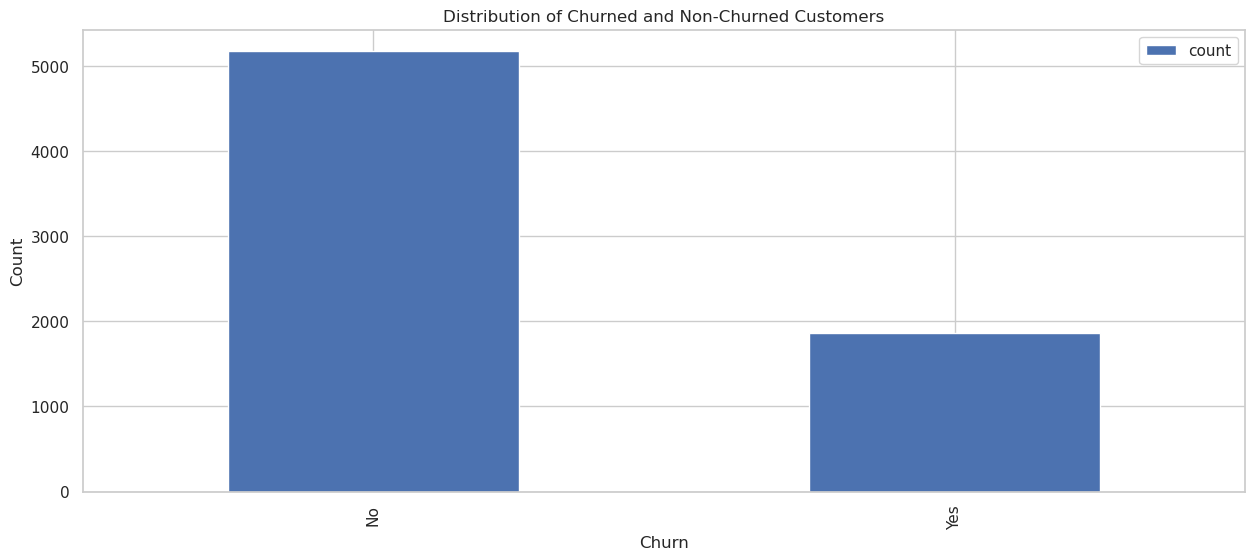

In [142]:
# 4.  Point
churn_count = df.groupBy('Churn').count().toPandas()
churn_count.plot(kind='bar', x='Churn', y='count')
plt.title('Distribution of Churned and Non-Churned Customers')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()


## 4. Final Model Evaluation
Report your best model with its AUC on the test and train sets.

In [192]:
# Best Model with AUC on train and test sets.
train_auc = aucEvaluator.evaluate(cvModel.transform(train)) #train
print(f"Train AUC: {train_auc:.4f}")

# AUC on test set
test_auc = aucEvaluator.evaluate(cvModel.transform(test)) #test
print(f"Test AUC: {test_auc:.4f}")


Train AUC: 0.8498
Test AUC: 0.8593


From the above the best model achieved so far is from hyper-parameter tuning having
AUC (train ): 0.8498 
and
AUC (test) : 0.8593 - explaining the model's ability to interpret positive and negative instances.

## 5. Notebook Organization

References: 
1. https://github.com/soltaniehha/Big-Data-Analytics-for-Business : for lecture notes & .ipynb notebook and previous lecture concept implementation
2. https://www.w3schools.com/python/matplotlib_pyplot.asp : Used for better graph learning opportunity and practice.
3. notebook 11-Classification-Regression/02-Logistic-Regression-Example.ipynb

In [204]:
# bm = cvModel.bestModel.summary
# print(bm)
# bestModelroc = bm.roc.toPandas()
# bestModelroc
# %matplotlib inline
# import matplotlib.pyplot as plt

# plt.plot(bestModelroc['FPR'], bestModelroc['TPR'], label='ROC Curve')
# plt.xlabel('False Positive Rate (FPR)')
# plt.ylabel('True Positive Rate (TPR)')
# plt.title('ROC Curve')
# plt.legend(loc='lower right')
# #print('Train AUC:', summary.areaUnderROC)
# bestModelpr = bm.pr.toPandas()
# bestModelpr
# bestModelpr.plot(x='recall', y='precision', style='--o', legend=False)
# plt.xlabel('Recall')
# plt.title('Precision-Recall Cruve')
# plt.ylabel('Precision')
# plt.legend(loc='upper right')